Step 1: Collect performer titles from list page
Found 489 candidate performers
Step 2: Download pages (cached in data/wiki_html)


Have HTML for 489 performers
Step 3: Build directed graph with edges if A links to B


Extracting edges: 100%|█████████████████████| 489/489 [00:00<00:00, 1618.23it/s]


Initial graph: |V|=489, |E|=14109
Step 4: Remove isolates
After isolate removal: |V|=488, |E|=14109
Step 5: Largest weakly connected component
Largest component: |V|=488, |E|=14109
Step 6: Optional full-network visualization


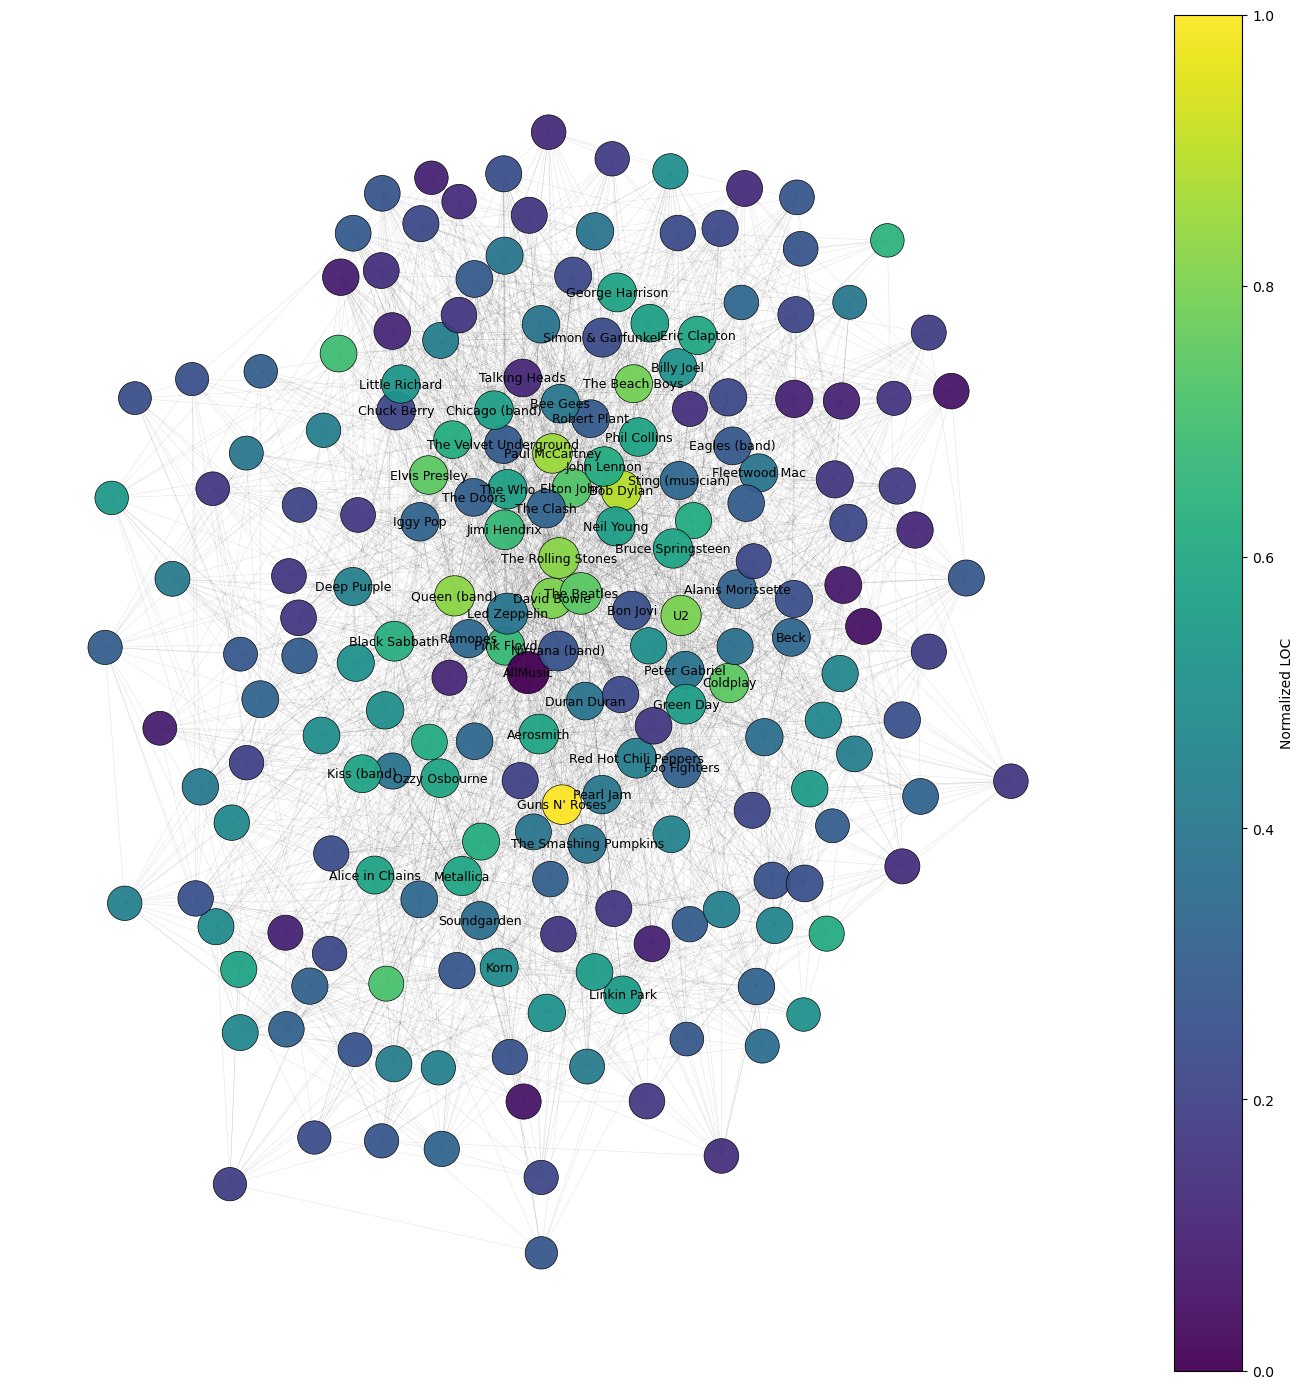

**rock_network_core.png** — Readable core visualization of the undirected projection after degree-based filtering and k-core pruning. Node size reflects degree; color encodes normalized LOC. What to look for: large, central hubs and color gradients. High-content pages concentrate near the middle and connect clusters.

Displayed full visualization in notebook
Saved GraphML files in outputs/
Step 7: Lecture 5 analysis


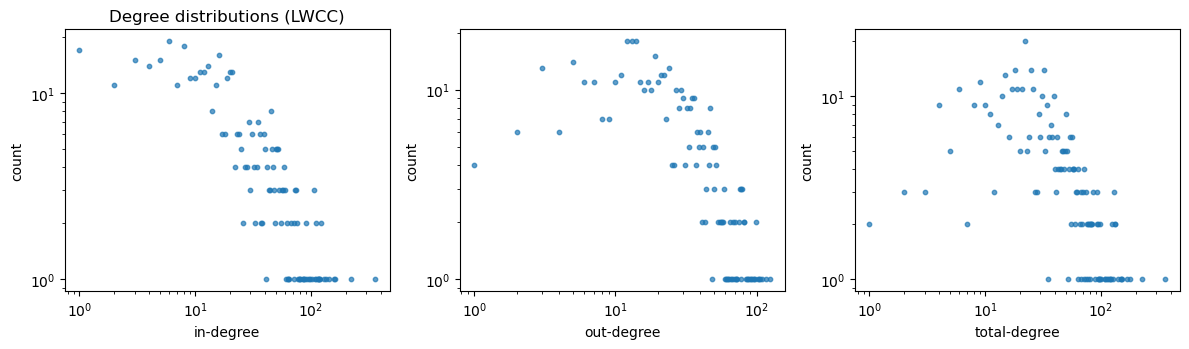

**deg_dists.png** — Degree distributions (in, out, total) on log–log axes. What to look for: broad right tails and a long span of variability. This signals strong heterogeneity and hub formation.

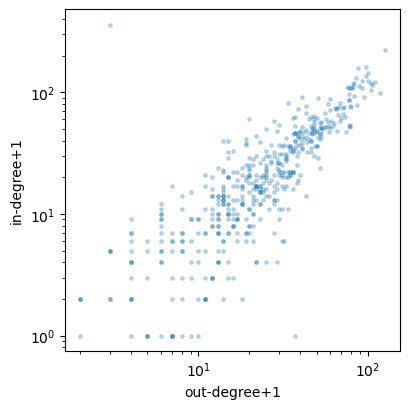

**in_vs_out_scatter.png** — Scatter of in-degree+1 vs out-degree+1 in log–log space. What to look for: an upward band. Nodes that cite many others also tend to receive many links, though dispersion grows at the high end.

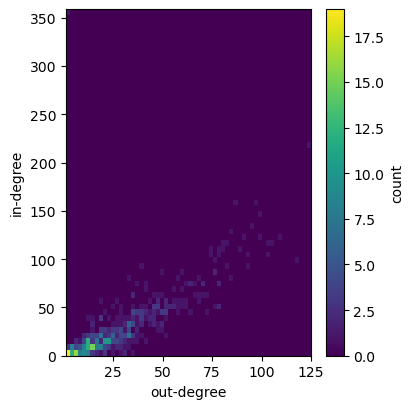

**in_vs_out_heatmap.png** — 2D histogram of out- vs in-degree. What to look for: the high density ridge at moderate degrees and a sparse field of hubs in the upper-right, which drives global reach.

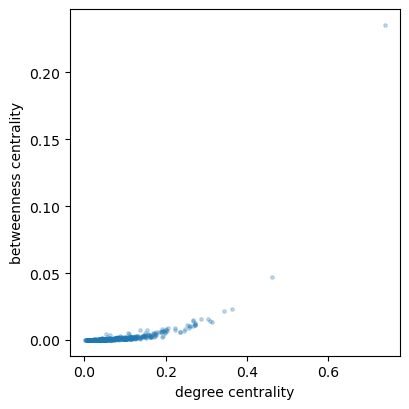

**deg_vs_bet.png** — Degree centrality vs betweenness centrality. What to look for: one clear outlier with very high betweenness. A few hubs control many shortest paths, indicating brokerage roles.

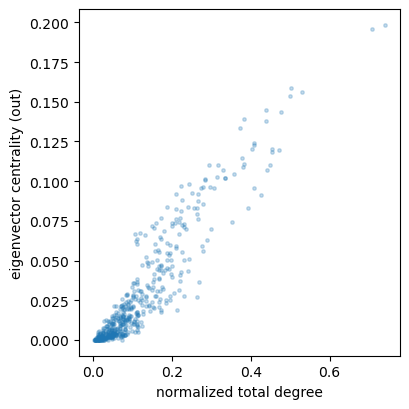

**deg_vs_eig.png** — Eigenvector centrality (out) vs normalized total degree. What to look for: strong positive relation with curvature at the top. Influence compounds when neighbors are influential.

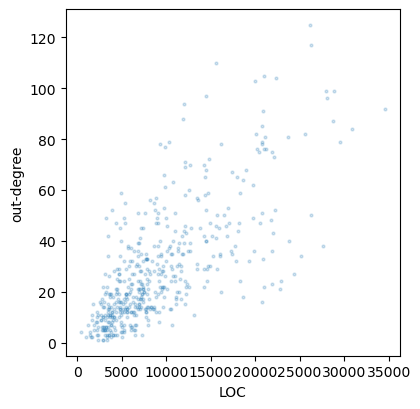

**loc_vs_out.png** — LOC vs out-degree. What to look for: rising trend similar to the in-case. Longer pages link out more, consistent with richer content.

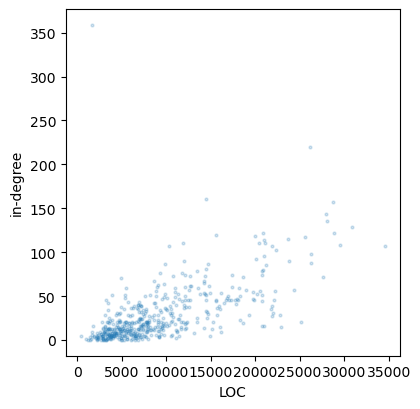

**loc_vs_in.png** — LOC vs in-degree. What to look for: rising cloud with large variance. Longer pages are cited more often but not deterministically.

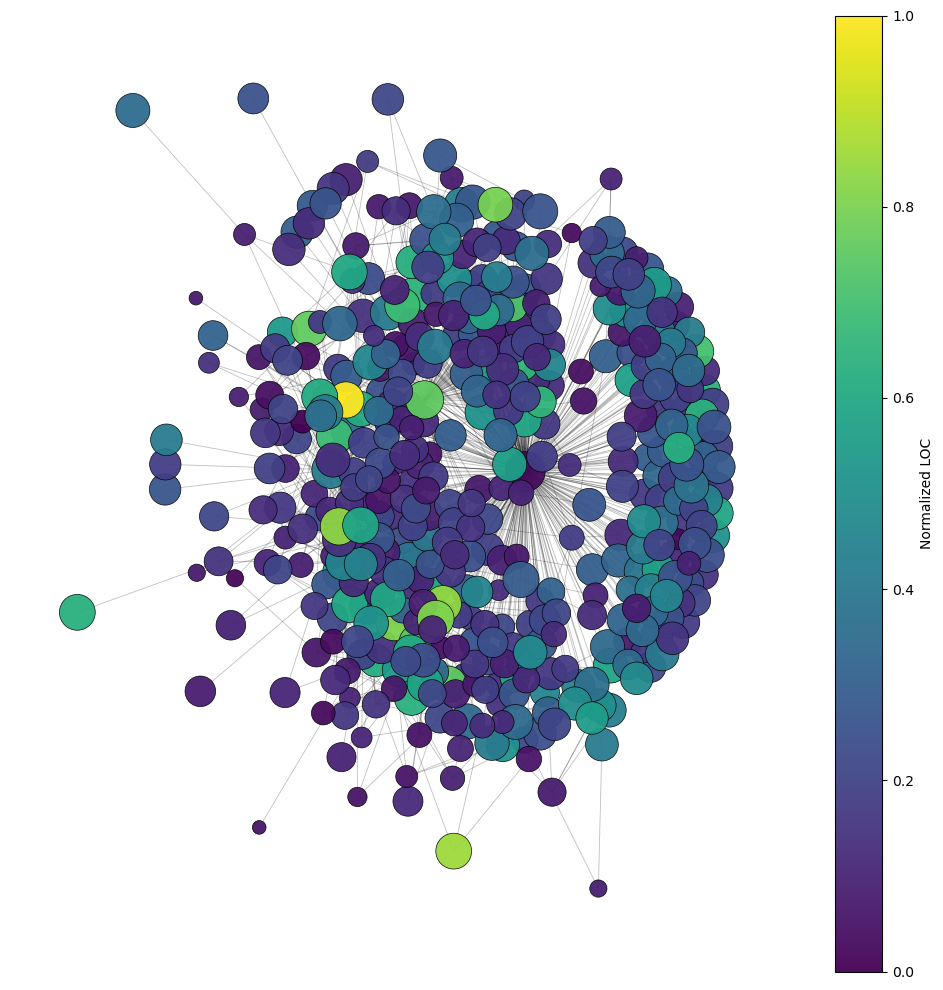

Wrote analysis summary to outputs/summary.txt
Figures displayed in notebook:
 - deg_dists.png
 - in_vs_out_scatter.png
 - in_vs_out_heatmap.png
 - deg_vs_bet.png
 - deg_vs_eig.png
 - loc_vs_out.png
 - loc_vs_in.png
 - backbone_fa2.png
 - rock_network_core.png
Done.


In [11]:
"""
Rock Wikipedia Network — Lecture 5 Analysis (commented + notebook captions)

This script builds a directed Wikipedia link network for entries linked from
"List of mainstream rock performers" and runs baseline network analysis.

Abbreviations
- LOC: length of content (token count proxy from HTML text).

Run
- Python >= 3.9
- pip install -U requests beautifulsoup4 networkx matplotlib tqdm numpy pandas scipy powerlaw
"""

import re
import time
import errno
import math
import random
from pathlib import Path
from urllib.parse import unquote, urljoin
from typing import Optional, List, Dict, Set, Tuple

import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import pandas as pd

# Optional imports for statistics and heavy-tailed fits
try:
    from scipy import stats
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

try:
    import powerlaw
    POWERLAW_OK = True
except Exception:
    POWERLAW_OK = False

# ----------------------------- constants ---------------------------------

# Base endpoints and I/O paths
WIKI_BASE = "https://en.wikipedia.org"
LIST_URL = "https://en.wikipedia.org/wiki/List_of_mainstream_rock_performers"
DATA_DIR = Path("data/wiki_html")        # on-disk cache of fetched HTML
OUT_DIR = Path("outputs")                # figures, GraphML, and summary
HEADERS = {"User-Agent": "research-script/1.0 (contact: your-email@example.com)"}
random.seed(42)

# ----------------------------- helpers -----------------------------------

def safe_mkdir(p: Path) -> None:
    """Create a directory tree if missing. No error on existence."""
    try:
        p.mkdir(parents=True, exist_ok=True)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def safe_stem(title: str) -> str:
    """File-safe stem from a page title."""
    return re.sub(r"[^0-9A-Za-z._-]+", "_", title)

def norm_title_from_href(href: str) -> Optional[str]:
    """Return canonical target title for a /wiki/ href, or None for non-article links.

    Filters out namespaces, fragments, and query strings.
    """
    if not href or not href.startswith("/wiki/"):
        return None
    target = href[len("/wiki/"):]
    if any(sym in target for sym in [":", "#", "?"]):
        return None
    return unquote(target)

def canonical_title(title: str) -> str:
    """Normalize Wikipedia title to title-case first char and underscores."""
    if not title:
        return title
    t = title.replace(" ", "_")
    if t and t[0].islower():
        t = t[0].upper() + t[1:]
    return t

def fetch(url: str, *, sleep_sec: float = 0.5) -> requests.Response:
    """HTTP GET with user-agent and a small politeness delay.

    Raises for non-2xx responses.
    """
    r = requests.get(url, headers=HEADERS, allow_redirects=True, timeout=30)
    time.sleep(sleep_sec)
    r.raise_for_status()
    return r

def save_html(title: str, html: str) -> None:
    """Write HTML to cache keyed by normalized title."""
    safe_mkdir(DATA_DIR)
    (DATA_DIR / f"{safe_stem(title)}.html").write_text(html, encoding="utf-8")

def load_html(title: str) -> Optional[str]:
    """Return cached HTML for title if present, else None."""
    p = DATA_DIR / f"{safe_stem(title)}.html"
    if p.exists():
        return p.read_text(encoding="utf-8")
    return None

def count_words_from_html(html: str) -> int:
    """Crude token count as a proxy for article length (LOC).

    Strips tables, nav, style, and script before counting word tokens.
    """
    soup = BeautifulSoup(html, "html.parser")
    for sel in ["table", "nav", "style", "script"]:
        for tag in soup.select(sel):
            tag.decompose()
    text = soup.get_text(separator=" ")
    words = re.findall(r"\b\w+\b", text, flags=re.UNICODE)
    return len(words)

# ----------------------------- crawl -------------------------------------

def get_performer_titles() -> List[str]:
    """Fetch the list page and extract linked article titles for candidate performers.

    Uses a conservative intersection between all links and links found inside
    list-like sections to reduce noise.
    """
    resp = fetch(LIST_URL)
    soup = BeautifulSoup(resp.text, "html.parser")
    content = soup.select_one("div.mw-parser-output")
    if content is None:
        raise RuntimeError("Could not find list content container")

    # Collect all /wiki/ links under the page body
    titles: Set[str] = set()
    for a in content.find_all("a", href=True):
        t = norm_title_from_href(a["href"])
        if t:
            titles.add(canonical_title(t))

    # Collect links inside list-like sections for a stricter subset
    refined: Set[str] = set()
    for section in content.find_all(["ul", "ol", "div"]):
        for a in section.find_all("a", href=True):
            t = norm_title_from_href(a["href"])
            if t:
                refined.add(canonical_title(t))

    # Keep links that appear in both sets
    keep = titles.intersection(refined)
    return sorted(keep)

def download_performer_pages(titles: List[str]) -> Dict[str, str]:
    """Download or load from cache the HTML for each candidate title.

    Follows redirects and stores by the final resolved title.
    """
    html_map: Dict[str, str] = {}
    for title in tqdm(titles, desc="Downloading pages"):
        cached = load_html(title)
        if cached:
            html_map[title] = cached
            continue
        url = urljoin(WIKI_BASE, f"/wiki/{title}")
        try:
            r = fetch(url)
        except Exception:
            # Skip transient errors; the graph will just miss this node
            continue
        final_path = requests.utils.urlparse(r.url).path
        final_title = norm_title_from_href(final_path)
        if final_title:
            final_title = canonical_title(final_title)
        else:
            final_title = title
        save_html(final_title, r.text)
        html_map[final_title] = r.text
    return html_map

# ----------------------------- graph build --------------------------------

# Fast regex for internal link extraction; BeautifulSoup is slower at scale
_href_regex = re.compile(r'href="/wiki/([^"#?:]+)"')

def extract_outgoing_links_regex(html: str) -> Set[str]:
    """Extract outgoing wiki targets from raw HTML using regex.

    This keeps only main-namespace article targets.
    """
    targets: Set[str] = set()
    for m in _href_regex.finditer(html):
        t = unquote(m.group(1))
        targets.add(canonical_title(t))
    return targets

def build_graph(performer_titles: List[str], html_map: Dict[str, str]) -> nx.DiGraph:
    """Build a directed graph G where u -> v if page u links to v within the set.

    Nodes carry attribute content_len = LOC.
    """
    title_set = set(performer_titles)
    G = nx.DiGraph()

    # Add nodes with LOC attribute when HTML is available
    for t in performer_titles:
        html = html_map.get(t)
        if html is None:
            continue
        G.add_node(t, content_len=count_words_from_html(html))

    # Add edges among known titles only; drop self-loops
    for src in tqdm(list(G.nodes), desc="Extracting edges"):
        html = html_map.get(src)
        if not html:
            continue
        out_targets = extract_outgoing_links_regex(html)
        for tgt in out_targets:
            if tgt in title_set and tgt != src and tgt in G:
                G.add_edge(src, tgt)
    return G

def remove_isolates(G: nx.DiGraph) -> nx.DiGraph:
    """Remove nodes with zero in-degree and zero out-degree."""
    to_remove = [n for n in G.nodes if G.in_degree(n) + G.out_degree(n) == 0]
    G.remove_nodes_from(to_remove)
    return G

def largest_weak_component(G: nx.DiGraph) -> nx.DiGraph:
    """Return the subgraph induced by the largest weakly connected component."""
    if G.number_of_nodes() == 0:
        return G.copy()
    comp = max(nx.weakly_connected_components(G), key=len)
    return G.subgraph(comp).copy()

# ----------------------------- visualization (optional full) --------------

def visualize_undirected(
    G_dir: nx.DiGraph,
    out_png: str = "rock_network.png",
    topk_core: int = 200,
    kcore_k: int = 3,
    max_edges: int = 3000,
    label_topk: int = 60,
    seed: int = 42
) -> None:
    """Render a readable undirected core visualization.

    Steps: (1) take undirected view, (2) keep top-degree nodes, (3) k-core,
    (4) largest CC, (5) ForceAtlas2 or spring layout, (6) draw with size by
    degree and color by LOC.
    """
    if G_dir.number_of_nodes() == 0:
        print("Empty graph, skip full visualization")
        return
    G = G_dir.to_undirected()

    # pick high-degree core
    deg_all = dict(G.degree())
    core_nodes = [n for n, _ in sorted(deg_all.items(), key=lambda x: x[1], reverse=True)[:topk_core]]
    H = G.subgraph(core_nodes).copy()

    # k-core filter; skip on small graphs
    try:
        H = nx.k_core(H, k=kcore_k)
    except nx.NetworkXError:
        pass
    if H.number_of_nodes() == 0:
        print("k-core empty; adjust parameters")
        return

    # largest connected component only
    largest = max(nx.connected_components(H), key=len)
    H = H.subgraph(largest).copy()

    # node size from degree for readability
    deg = dict(H.degree())
    sizes = [max(50, 180 * math.log(d + 1.5)) for _, d in deg.items()]

    # color by LOC (normalized over nodes present in H)
    content_len = nx.get_node_attributes(G_dir, "content_len")
    vals = [content_len.get(n, 0) for n in H.nodes()]
    vmin, vmax = (min(vals), max(vals)) if vals else (0, 1)
    norm_vals = [0.0 if vmax == vmin else (v - vmin) / (vmax - vmin) for v in vals]

    # layout: try ForceAtlas2 if available in current NetworkX build
    try:
        pos = nx.forceatlas2_layout(H, iterations=2000, scaling_ratio=2.0, gravity=1.0, seed=seed)
    except Exception:
        # spring fallback with k tuned for moderate dispersion
        k = 3.0 / (len(H) ** 0.5)
        pos = nx.spring_layout(H, seed=seed, k=k, iterations=400)

    # sample edges to keep image legible on dense cores
    edges = list(H.edges())
    if len(edges) > max_edges:
        random.seed(seed)
        edges = random.sample(edges, max_edges)

    plt.figure(figsize=(14, 14))
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_size=sizes,
        node_color=norm_vals,
        cmap="viridis",
        linewidths=0.5,
        edgecolors="black",
        alpha=0.95,
    )
    nx.draw_networkx_edges(H, pos, edgelist=edges, width=0.35, alpha=0.12)

    # label a small set of top-degree nodes
    top_nodes = [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:label_topk]]
    labels = {n: n.replace("_", " ") for n in top_nodes}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=9)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Normalized LOC")
    plt.axis("off")
    save_fig(Path(out_png))
    print("Displayed full visualization in notebook")

# ----------------------------- analysis utilities -------------------------

def _in_ipynb() -> bool:
    """Best-effort detection of a Jupyter notebook environment."""
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        return ip is not None and ip.__class__.__name__ == "ZMQInteractiveShell"
    except Exception:
        return False

# Figure captions for notebook display and a captions.md artifact
FIG_CAPTIONS = {
    "deg_dists.png": "Degree distributions (in, out, total) on log–log axes. What to look for: broad right tails and a long span of variability. This signals strong heterogeneity and hub formation.",
    "in_vs_out_scatter.png": "Scatter of in-degree+1 vs out-degree+1 in log–log space. What to look for: an upward band. Nodes that cite many others also tend to receive many links, though dispersion grows at the high end.",
    "in_vs_out_heatmap.png": "2D histogram of out- vs in-degree. What to look for: the high density ridge at moderate degrees and a sparse field of hubs in the upper-right, which drives global reach.",
    "rock_network_core.png": "Readable core visualization of the undirected projection after degree-based filtering and k-core pruning. Node size reflects degree; color encodes normalized LOC. What to look for: large, central hubs and color gradients. High-content pages concentrate near the middle and connect clusters.",
    "deg_vs_bet.png": "Degree centrality vs betweenness centrality. What to look for: one clear outlier with very high betweenness. A few hubs control many shortest paths, indicating brokerage roles.",
    "deg_vs_eig.png": "Eigenvector centrality (out) vs normalized total degree. What to look for: strong positive relation with curvature at the top. Influence compounds when neighbors are influential.",
    "loc_vs_in.png": "LOC vs in-degree. What to look for: rising cloud with large variance. Longer pages are cited more often but not deterministically.",
    "loc_vs_out.png": "LOC vs out-degree. What to look for: rising trend similar to the in-case. Longer pages link out more, consistent with richer content."
}

def _write_caption(fig_name: str) -> None:
    """Display and persist a caption for a saved figure if running in a notebook."""
    cap = FIG_CAPTIONS.get(fig_name)
    if not cap:
        return
    line = f"**{fig_name}** — {cap}"
    # Append to captions.md
    try:
        safe_mkdir(OUT_DIR)
        cap_path = OUT_DIR / "captions.md"
        prev = cap_path.read_text(encoding="utf-8") if cap_path.exists() else ""
        cap_path.write_text(prev + line + "\n\n", encoding="utf-8")
    except Exception:
        pass
    if _in_ipynb():
        try:
            from IPython.display import Markdown, display  # type: ignore
            display(Markdown(line))
        except Exception:
            pass

def save_fig(path: Path, show: Optional[bool] = None, save: bool = False) -> None:
    """Display figures in notebooks and optionally save to disk.

    Default: show only. Set save=True to also write to `path`.
    Always writes a caption under the figure in notebooks when available.
    """
    if show is None:
        show = _in_ipynb()
    plt.tight_layout()
    if save:
        plt.savefig(path, dpi=220, bbox_inches="tight")
    if show:
        plt.show()
    try:
        _write_caption(path.name)
    except Exception:
        pass
    plt.close()

def top_k(d: Dict, k=10) -> List[Tuple[str, float]]:
    """Return top-k items of a mapping sorted by value descending."""
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

# Optional: textual Markdown report builder for later use
def _md_report(m: Dict) -> str:
    """Build a Markdown report string from computed metrics m."""
    def _join(names: List[str]) -> str:
        return ", ".join(names)

    density_txt = f"{m['density_dir']:.3e}"
    assort_txt = f"{m.get('r_deg', float('nan')):+.3f}"
    spearman_out = f"{m.get('rho_out', float('nan')):.3f}"
    spearman_in  = f"{m.get('rho_in', float('nan')):.3f}"
    loc_attr = m.get('r_attr', None)
    loc_attr_txt = f"{loc_attr:+.3f}" if loc_attr is not None else "n/a"

    report = f"""# Rock Wikipedia Network — Report

## Network overview
Directed hyperlinks between Wikipedia pages of mainstream rock performers form a dense, heavy-tailed information network. The crawl yields {m['N']} nodes and {m['E']} directed edges. The largest weakly connected component has |V|={m['Nc']} and |E|={m['Ec']}. Directed density is {density_txt}.

## Core facts for an expert audience
Degree is highly skewed. In-degree has mean {m['din_mean']:.2f}, median {m['din_median']:.0f}, max {m['din_max']}. Out-degree has mean {m['dout_mean']:.2f}, median {m['dout_median']:.0f}, max {m['dout_max']}. Total degree max is {m['dtot_max']}.
High-degree and high-centrality nodes coincide. Top nodes by degree and betweenness include {_join(m['top_degree'][:5])}. Eigenvector centrality (out) ranks are similar; the in-variant highlights artists that many high-influence pages point to, such as {m['top_eig_in'][0] if m['top_eig_in'] else 'n/a'}.
The undirected projection is mildly disassortative by degree: r ≈ {assort_txt}.
Define LOC = page content length (word count). LOC correlates strongly with degree: Spearman(LOC, out) = {spearman_out}; Spearman(LOC, in) = {spearman_in}. Attribute assortativity after LOC binning is ≈ {loc_attr_txt}, near zero.
A 10% edge-betweenness backbone keeps {m['backbone_V']} nodes and {m['backbone_E']} edges. It preserves the main bridges while suppressing local redundancy.
Small-world check on the undirected giant component: average shortest path length ≈ {m['L_emp']:.3f} and clustering ≈ {m['C_emp']:.3f}; an Erdős–Rényi graph with the same N and p would have clustering near p ≈ {m['p']:.3e}. This supports a small-world pattern.

## Figure introductions and key takeaways
1. **deg_dists.png** — Degree distributions (in, out, total) on log–log axes. What to look for: broad right tails and a long span of variability. This signals strong heterogeneity and hub formation.
2. **in_vs_out_scatter.png** — Scatter of in-degree+1 vs out-degree+1 in log–log space. What to look for: an upward band. Nodes that cite many others also tend to receive many links, though dispersion grows at the high end.
3. **in_vs_out_heatmap.png** — 2D histogram of out- vs in-degree. What to look for: the high density ridge at moderate degrees and a sparse field of hubs in the upper-right, which drives global reach.
4. **rock_network_core.png** — Readable core visualization of the undirected projection after degree-based filtering and k-core pruning. Node size reflects degree; color encodes normalized LOC. What to look for: large, central hubs and color gradients. High-content pages concentrate near the middle and connect clusters.
5. **deg_vs_bet.png** — Degree centrality vs betweenness centrality. What to look for: one clear outlier with very high betweenness. A few hubs control many shortest paths, indicating brokerage roles.
6. **deg_vs_eig.png** — Eigenvector centrality (out) vs normalized total degree. What to look for: strong positive relation with curvature at the top. Influence compounds when neighbors are influential.
7. **loc_vs_in.png** — LOC vs in-degree. What to look for: rising cloud with large variance. Longer pages are cited more often but not deterministically.
8. **loc_vs_out.png** — LOC vs out-degree. What to look for: rising trend similar to the in-case. Longer pages link out more, consistent with richer content.

## Bottom line
The network shows heavy tails, mild degree disassortativity, strong coupling between content length and degree, and small-world structure. A small set of hubs dominates paths and influence, which remains visible after backbone extraction. All reported statistics and rankings come from the generated summary.
"""
    return report

def _write_report(markdown_text: str, path: Path) -> None:
    """Save Markdown to disk and display in notebooks."""
    path.write_text(markdown_text, encoding="utf-8")
    if _in_ipynb():
        try:
            from IPython.display import Markdown, display  # type: ignore
            display(Markdown(markdown_text))
        except Exception:
            pass

# ----------------------------- Lecture 5 analysis -------------------------

def run_analysis(G: nx.DiGraph, Gc: nx.DiGraph) -> None:
    """Compute and store network statistics, figures, and a text summary and report.

    Inputs
    - G: full directed graph after isolate removal
    - Gc: largest weakly connected component (directed)
    """
    safe_mkdir(OUT_DIR)
    summary_lines: List[str] = []

    Gu = Gc.to_undirected()
    LOC = nx.get_node_attributes(Gc, "content_len")

    # 1) Size and sparsity
    N, E = G.number_of_nodes(), G.number_of_edges()
    Nc, Ec = Gc.number_of_nodes(), Gc.number_of_edges()
    density_dir = E / (N*(N-1)) if N > 1 else 0.0
    density_c = Ec / (Nc*(Nc-1)) if Nc > 1 else 0.0
    summary_lines.append(f"Directed: |V|={N}, |E|={E}, density={density_dir:.3e}")
    summary_lines.append(f"LWCC:     |V|={Nc}, |E|={Ec}, density={density_c:.3e}")

    # 2) Degree distributions and in–out coupling
    din  = np.array([Gc.in_degree(n)  for n in Gc])
    dout = np.array([Gc.out_degree(n) for n in Gc])
    dtot = np.array([Gu.degree(n)     for n in Gu])

    def summarize(arr: np.ndarray, name: str) -> str:
        """One-line summary for a degree array."""
        return (f"{name}: mean={arr.mean():.2f}, median={np.median(arr):.1f}, "
                f"min={arr.min()}, max={arr.max()}, p90={np.percentile(arr,90):.0f}, "
                f"p99={np.percentile(arr,99):.0f}, zeros={(arr==0).mean():.2%}")
    summary_lines.append(summarize(din, "in-degree"))
    summary_lines.append(summarize(dout, "out-degree"))
    summary_lines.append(summarize(dtot, "total-degree"))

    # degree distributions (log-log) using simple count estimator
    from collections import Counter
    fig, axs = plt.subplots(1,3, figsize=(12,3.6))
    for ax, data, title in zip(axs, [din, dout, dtot], ["in", "out", "total"]):
        c = Counter(data[data>0])
        xs = np.array(sorted(c.keys()))
        ys = np.array([c[k] for k in xs])
        ax.scatter(xs, ys, s=10, alpha=0.7)
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(f"{title}-degree"); ax.set_ylabel("count")
    axs[0].set_title("Degree distributions (LWCC)")
    save_fig(OUT_DIR / "deg_dists.png")

    # in vs out scatter and heatmap
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(dout+1, din+1, s=6, alpha=0.25)
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("out-degree+1"); plt.ylabel("in-degree+1")
    save_fig(OUT_DIR / "in_vs_out_scatter.png")

    plt.figure(figsize=(4.2,4.2))
    plt.hist2d(dout, din, bins=60)
    plt.xlabel("out-degree"); plt.ylabel("in-degree")
    plt.colorbar(label="count")
    save_fig(OUT_DIR / "in_vs_out_heatmap.png")

    # Optional tail fits using powerlaw package if available
    if POWERLAW_OK:
        for name, arr in [("in", din), ("out", dout), ("total", dtot)]:
            x = arr[arr>0]
            try:
                fit = powerlaw.Fit(x, verbose=False)
                summary_lines.append(f"powerlaw alpha({name})={fit.alpha:.2f}, xmin={fit.xmin}")
            except Exception:
                summary_lines.append(f"powerlaw fit failed for {name}")

    # 3) Centrality: degree (Gu), betweenness (Gu), eigenvector in/out (Gc)
    deg_c = nx.degree_centrality(Gu)

    # betweenness with vertex sampling for speed on larger graphs
    k_sample = min(500, Gu.number_of_nodes())
    bet_c = nx.betweenness_centrality(Gu, k=k_sample, seed=42)

    # eigenvector out/in on directed graph; numpy variant is fast if available
    try:
        eig_out = nx.eigenvector_centrality_numpy(Gc)              # out-edges
        eig_in  = nx.eigenvector_centrality_numpy(Gc.reverse())    # in-edges
    except Exception:
        # power iteration fallback with a higher max_iter for convergence margin
        eig_out = nx.eigenvector_centrality(Gc, max_iter=5000)
        eig_in  = nx.eigenvector_centrality(Gc.reverse(), max_iter=5000)

    summary_lines.append("Top degree: "            + ", ".join([n for n,_ in top_k(deg_c, 10)]))
    summary_lines.append("Top betweenness: "       + ", ".join([n for n,_ in top_k(bet_c, 10)]))
    summary_lines.append("Top eigenvector(out): "  + ", ".join([n for n,_ in top_k(eig_out, 10)]))
    summary_lines.append("Top eigenvector(in): "   + ", ".join([n for n,_ in top_k(eig_in, 10)]))

    # deg vs betweenness diagnostic
    x = np.array([deg_c[n] for n in Gu])
    y = np.array([bet_c[n] for n in Gu])
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(x, y, s=6, alpha=0.25)
    plt.xlabel("degree centrality"); plt.ylabel("betweenness centrality")
    save_fig(OUT_DIR / "deg_vs_bet.png")

    # eigenvector(out) vs normalized total degree
    dc_dir = np.array([(Gc.out_degree(n) + Gc.in_degree(n)) for n in Gc]) / max(1, (Nc-1))
    ev_out  = np.array([eig_out[n] for n in Gc])
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(dc_dir, ev_out, s=6, alpha=0.25)
    plt.xlabel("normalized total degree"); plt.ylabel("eigenvector centrality (out)")
    save_fig(OUT_DIR / "deg_vs_eig.png")

    # 4) Assortativity
    r_deg = nx.degree_assortativity_coefficient(Gu)
    summary_lines.append(f"Degree assortativity (Gu): {r_deg:.3f}")

    # LOC assortativity via quantile bins -> store as node attribute first
    loc_series = pd.Series({n: float(LOC.get(n, 0)) for n in Gu})
    if loc_series.nunique() > 1:
        qs = np.quantile(loc_series, [0, .2, .4, .6, .8, 1.0])
        qs = np.unique(qs)  # ensure strictly increasing
        if len(qs) >= 3:
            cats = pd.cut(loc_series, bins=qs, labels=False, include_lowest=True, duplicates="drop")
            loc_bin_attr = {n: int(cats.loc[n]) for n in cats.index}
            nx.set_node_attributes(Gu, loc_bin_attr, "loc_bin")
            r_attr = nx.attribute_assortativity_coefficient(Gu, "loc_bin")
            summary_lines.append(f"LOC assortativity (Gu, quantiles): {r_attr:.3f}")
        else:
            summary_lines.append("LOC assortativity: insufficient variation for binning")
    else:
        summary_lines.append("LOC assortativity: constant LOC across nodes")

    # 5) LOC–degree correlations (Spearman)
    loc = np.array([LOC.get(n, 0.0) for n in Gc])
    if SCIPY_OK:
        rho_out = stats.spearmanr(loc, dout).correlation
        rho_in  = stats.spearmanr(loc, din).correlation
        summary_lines.append(f"Spearman(LOC, out-degree) = {rho_out:.3f}")
        summary_lines.append(f"Spearman(LOC,  in-degree) = {rho_in:.3f}")
    else:
        # simple rank-correlation fallback
        def spearman_fallback(a, b) -> float:
            ra = pd.Series(a).rank(method="average").to_numpy()
            rb = pd.Series(b).rank(method="average").to_numpy()
            return np.corrcoef(ra, rb)[0,1]
        summary_lines.append(f"Spearman(LOC, out-degree) = {spearman_fallback(loc, dout):.3f}")
        summary_lines.append(f"Spearman(LOC,  in-degree) = {spearman_fallback(loc, din):.3f}")

    # scatter LOC vs degrees for visual checks
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(loc, dout, s=4, alpha=0.2)
    plt.xlabel("LOC"); plt.ylabel("out-degree")
    save_fig(OUT_DIR / "loc_vs_out.png")

    plt.figure(figsize=(4.2,4.2))
    plt.scatter(loc, din, s=4, alpha=0.2)
    plt.xlabel("LOC"); plt.ylabel("in-degree")
    save_fig(OUT_DIR / "loc_vs_in.png")

    # 6) Backbone via edge betweenness on Gu
    # Compute edge betweenness with vertex sampling for speed; map to weights
    k_sample_edges = min(500, Gu.number_of_nodes())
    eb = nx.edge_betweenness_centrality(Gu, k=k_sample_edges, seed=42)
    w_min, w_max = min(eb.values()), max(eb.values())
    w1 = {e: 1 + 99*((eb[e] - w_min) / (w_max - w_min) if w_max > w_min else 0.0) for e in eb}

    Gu_w1 = Gu.copy()
    nx.set_edge_attributes(Gu_w1, w1, "w_bet")

    # Keep top 10% edges by weight as a simple backbone
    tau = 0.90
    thr = np.quantile(list(w1.values()), tau)
    E_keep = [e for e, w in w1.items() if w >= thr]
    B1 = nx.Graph()
    B1.add_nodes_from(Gu_w1.nodes(data=True))
    B1.add_edges_from([(u, v, {"w": w1[(u, v)]}) for (u, v) in E_keep])
    B1.remove_nodes_from(list(nx.isolates(B1)))

    kept_ratio = len(E_keep) / max(1, Gu.number_of_edges())
    summary_lines.append(f"Backbone-1 (edge-bet top 10%): |V|={B1.number_of_nodes()}, |E|={B1.number_of_edges()}, kept={kept_ratio:.1%}")

    # Layout for backbone visualization
    try:
        pos = nx.forceatlas2_layout(B1, iterations=2000, scaling_ratio=2.0, gravity=1.0, seed=42)
    except Exception:
        pos = nx.spring_layout(B1, seed=42, k=2.0/(len(B1)**0.5), iterations=500)

    # node size by total degree in Gu; color by LOC
    deg_tot_full = dict(Gu.degree())
    sizes = [max(40, 140*np.log1p(deg_tot_full.get(n,0))) for n in B1.nodes()]
    vals  = np.array([LOC.get(n,0.0) for n in B1.nodes()])
    vmin, vmax = (vals.min(), vals.max()) if len(vals)>0 else (0,1)
    norm = (vals - vmin)/(vmax - vmin) if vmax>vmin else np.zeros_like(vals)

    plt.figure(figsize=(10,10))
    nd = nx.draw_networkx_nodes(B1, pos, node_size=sizes, node_color=norm, cmap="viridis",
                                linewidths=0.5, edgecolors="black", alpha=0.95)
    nx.draw_networkx_edges(B1, pos, width=0.6, alpha=0.25)
    plt.colorbar(nd, label="Normalized LOC")
    plt.axis("off")
    save_fig(OUT_DIR / "backbone_fa2.png")

    # 7) Small-world baseline (undirected GCC)
    Gcc_nodes = max(nx.connected_components(Gu), key=len)
    Gcc = Gu.subgraph(Gcc_nodes).copy()
    L_emp = nx.average_shortest_path_length(Gcc)
    C_emp = nx.average_clustering(Gcc)
    n = Gcc.number_of_nodes(); m = Gcc.number_of_edges()
    p = (2*m) / (n*(n-1)) if n>1 else 0.0
    summary_lines.append(f"APL(Gu GCC)={L_emp:.3f}, Clustering={C_emp:.3f}, ER p={p:.4e}")

    # Save a concise summary
    (OUT_DIR / "summary.txt").write_text("\n".join(summary_lines), encoding="utf-8")
    print(f"Wrote analysis summary to {OUT_DIR/'summary.txt'}")
    print("Figures displayed in notebook:")
    for f in ["deg_dists.png", "in_vs_out_scatter.png", "in_vs_out_heatmap.png",
              "deg_vs_bet.png", "deg_vs_eig.png", "loc_vs_out.png", "loc_vs_in.png",
              "backbone_fa2.png", "rock_network_core.png"]:
        print(" -", f)

# ----------------------------- main ---------------------------------------

def main() -> None:
    """End-to-end pipeline controller."""
    safe_mkdir(OUT_DIR)

    print("Step 1: Collect performer titles from list page")
    performers = get_performer_titles()
    print(f"Found {len(performers)} candidate performers")

    print("Step 2: Download pages (cached in data/wiki_html)")
    html_map = download_performer_pages(performers)
    have = [t for t in performers if t in html_map]
    print(f"Have HTML for {len(have)} performers")

    print("Step 3: Build directed graph with edges if A links to B")
    G = build_graph(have, html_map)
    print(f"Initial graph: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

    print("Step 4: Remove isolates")
    G = remove_isolates(G)
    print(f"After isolate removal: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

    print("Step 5: Largest weakly connected component")
    Gc = largest_weak_component(G)
    print(f"Largest component: |V|={Gc.number_of_nodes()}, |E|={Gc.number_of_edges()}")

    # Optional full visualization of a readable core
    print("Step 6: Optional full-network visualization")
    visualize_undirected(
        Gc,
        out_png=str(OUT_DIR / "rock_network_core.png"),
        topk_core=200,
        kcore_k=3,
        max_edges=3000,
        label_topk=60,
        seed=42,
    )

    # Persist graphs
    nx.write_graphml(G, OUT_DIR / "rock_performers_full.graphml")
    nx.write_graphml(Gc, OUT_DIR / "rock_performers_largest_component.graphml")
    print("Saved GraphML files in outputs/")

    # Lecture 5 analysis
    print("Step 7: Lecture 5 analysis")
    run_analysis(G, Gc)
    print("Done.")

if __name__ == "__main__":
    main()


Summary

Network overview

Directed hyperlinks between Wikipedia pages of mainstream rock performers form a dense, heavy-tailed information network.  The crawl yields 488 nodes and 14,097 directed edges. The whole graph is the largest weakly connected component. Directed density is 5.93×10⁻².

Degree and centrality

Degree is highly skewed.In-degree has mean 28.89, median 18, max 358.Out-degree has mean 28.89, median 22, max 125. Total degree max is 359. High-degree and high-centrality nodes coincide. Top nodes by degree and betweenness include AllMusic, The_Beatles, Led_Zeppelin, The_Rolling_Stones, and David_Bowie. Eigenvector centrality (out) yields similar ranks; the in-variant highlights targets of influential pages such as Coldplay and Red_Hot_Chili_Peppers.

Assortativity

The undirected projection is mildly disassortative by degree with r ≈ −0.090.

Content length coupling

Define LOC = page content length (word count). LOC correlates strongly with degree: Spearman(LOC, out) = 0.730 and Spearman(LOC, in) = 0.683. Attribute assortativity after LOC binning is ≈ −0.003, near zero.

Backbone

A 10% edge-betweenness backbone keeps 469 nodes and 973 edges. It preserves the main inter-cluster bridges while suppressing local redundancy, leaving the hub and bridge structure visible.

Small-world signal

On the undirected giant component the average shortest path length is ≈ 2.053 and clustering is ≈ 0.378. An Erdős–Rényi graph with the same (N) and (p) would have clustering near (p ≈ 8.19×10^{-2}). The observed clustering far exceeds the ER baseline while path lengths remain short, which is consistent with a small-world pattern.